# Break Down of running a network on CIFAR10
Hi all, this is a notebook to help break down running a network on CIFAR10. It will be similar to the tutorial on the PyTorch website; however, I'll go over some pointers for making some deep learning code more modular, specfic issues you may run into with your assignment, and a few extra things for those who are intrested.

## Imports
torch - PyTorch module 

torchvision - PyTorch Vision library

torch.optim - PyTorch optimizer module, you implimented SGD


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

## Importing the CIFAR10 dataset
PyTorch vision makes it really easy to import some of the well known datasets here's more information on some of them: https://pytorch.org/docs/stable/torchvision/datasets.html 

In [18]:
# data transformation to normalize data
# normalizing data helps your optimization algorithm converge more quickly
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# training set split

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)

# testing set split, this portion is similar to your assignment
# but instead of passing in trainset you need to pass in an instance 
# of a custom data object which is provided in the starter code

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=10,
                                         shuffle=False, 
                                         num_workers=2)

# labeling the classes of images just like the digits of MNIST, or the 
# the breeds of dogs from DogNet

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


## Using the GPU

One of the most best ways to speed up the training process of a deep network is to use a GPU (or TPU if you can). This is because with a GPU we can train a whole batch of data in parallel. This section is optinal and i'll mark the other parts of the code where this comes up. But, for those of you intrested and able to utilze a GPU I highly reccomend it! To do so just install CUDA and update your GPU drivers. 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
print('Using device: ', device)

Using device:  cuda


## Plotting the images

This function just plots some of the imagges from the training set, I would pay attention to this section because it can help make plotting the images from dogset and synth data a lot easier. 

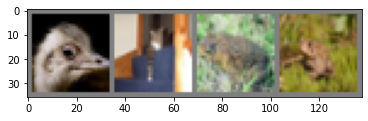

 bird   cat  frog  frog


In [19]:
def imshow(img):
    img = img/2  +0.5  # have to unnormalize the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Building your network
Below we build a simple network and the forward pass of the network. On the PyTorch website they use some notation which is slightly dated.

`import torch.nn.functional as F
F.relu(...)`

Most activation functions are just in the torch.nn module now. 


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


net = Net()

## Training and Testing Functions
Here I've just made the training and testing portions of the orignal tutorial into functions. I added some more comments to further break down what's going on.

In [ ]:
def train_model(model, criterion, optimizer, trainloader, epochs=10, devloader=None, print_info=True):
    epochs_loss = []
    epoch_acc = []
    running_loss = 0.0
    # the length of the train loader will give you the number of mini-batches
    # not the cleanest solution but for now it generalizes well and avoids 
    # computation that we don't need
    minibatches = len(trainloader)
    # moving the network onto the gpu/cpu
    model = model.to(device)
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch, labels in trainloader:
            # batch is a tensor with m elements, where each element is 
            # a training example
            
            # moving batch/labels onto the gpu/cpu
            batch, labels = batch.to(device), labels.to(device)
            
            # zeroing the parameters of the model 
            # becuase we want to optimize them
            optimizer.zero_grad()
            
            # forward pass
            # getting the predictions from our model by passing in a mini-batch
            # the ouput will have shape (mini-batch-size, number-of-classes)
            # where each element of output is the probabliity of that example being
            # the classification correspoding to the index of the value
            output = model(batch)
            loss = criterion(output, labels)
            
            # backward pass
            loss.backward()
            
            # optimize the parameters
            optimizer.step()
            
            # add the loss of a mini-batch to the list of epoch loss
            epoch_loss += loss.item()

        #  after each epoch we need to average out the loss across all minibatches
        epochs_loss.append(epoch_loss/minibatches)
        # printing some info
        if print_info:
            print(f'Epoch: {epoch} Loss: {epoch_loss/minibatches}')
    return model, epoch_loss
                

In [10]:
def test_model(model, testloader):
    # variables to keep count of correct labels and the total labels in a mini batch
    correct = 0
    total = 0
    # since we're testing the model we don't need to perform backprop
    with torch.no_grad():
        for batch, labels in testloader:
            batch, labels = batch, labels
            output = net(batch)
            # this gives us the index with the highest value outputed from the last layer
            # which coressponds to the most probable label/classification for an image
            predicted = torch.max(output.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

## Putting it together 
Here we make a model from the Net() and train it for 100 epochs, and then test it on our testing data we set aside earlier.

In [17]:
net = Net()
net, loss = train_model(net,
                        epochs=1,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999)),
                        trainloader=trainloader
                        )
net.to('cpu')
test_model(net, testloader)

Epoch: 0 Loss: 1.6318558282852174 bs: 0
Accuracy of the network on the 10000 test images: 45 %


## Saving and loading a model
When working with a network it can take a long time to train. To save sometime if you have to come back to a project you can save the weights of a model using the cell below. The cell following just shows how you can load the saved model.

In [101]:
# saving a model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


In [76]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>